<a href="https://colab.research.google.com/github/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/choixSejourLogiqueFloue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séjours dans le flou avec skfuzzy

L'objectif est de pouvoir représenter des règles de type :
- SI le beau temps est prévu ALORS j’achète l’offre de location pour une longue durée
- SI le temps est de moyen à beau, ET que la location reste abordable, ALORS j’achète l’offre pour une moyenne durée
- SI le temps prévu est mauvais, MAIS que la location est très abordable, ALORS j’achète l’offre pour une courte durée
- le reste du temps, SI la location est chère ET qu’il ne fait pas beau, ALORS je n’y vais pas ; de même SI la location est dans des prix abordable MAIS qu’il fait mauvais

On utilise pour cela la librairie python skfuzzy
*(si elle n'est pas présente, installez là avec cette ligne : !pip install -U scikit-fuzzy)*

In [0]:
 !pip install -U scikit-fuzzy

In [0]:
#les imports
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

## les antécédents et les conséquents
- Les antécédents sont les variables utilisées pour prendre les décisions (ici la météo, le coût)
- les conséquents sont les déductions (ici la durée de séjour)

In [0]:
#### Antecedent et Consequent
# la taille est située dans un intervale de 0 à 40 coupé par pas de 1 
meteo = ctrl.Antecedent(np.arange(0,40,1), 'meteo')
# l'offre de séjour est située dans un intervale de 0 à 200 la nuit, coupé par pas de 5
offre = ctrl.Antecedent(np.arange(0,200,5), 'offre')
# la durée de séjour est située dans un intervale de 0 à 5 coupé par pas de 0.5 
duree = ctrl.Consequent(np.arange(0,5,0.5), 'duree')

### intervales
on définit ensuite les intervales utilisés dans les antécédents et les conséquents.
- le temps est beau à partir de 22°, moyen à partir de 15°, frais en dessous


In [0]:
#une courbe trapezoïdale, moche=1 jusque 11°, petit=0 à partir de 15°
meteo_moche = fuzz.trapmf(meteo.universe, [0, 0, 11,15])
#une courbe trapezoïdale, moyenne=0 jusque 13°, moyenne=1 à partir de 15°, à 0 à partir de 20°
meteo_moyenne = fuzz.trapmf(meteo.universe, [13, 15, 20,22])
#une courbe trapezoïdale, belle=0 jusque 20°, belle=1 à partir de 22°
meteo_belle = fuzz.trapmf(meteo.universe, [20, 22, 40,40])
meteo['moche'] = meteo_moche
meteo['moyenne'] = meteo_moyenne
meteo['belle'] = meteo_belle


On peut vérifier les courbes d'appartenance : 

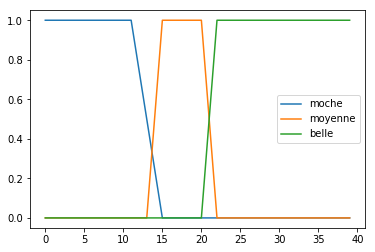

In [125]:
plt.plot(meteo.universe, meteo_moche,  label='moche')
plt.plot(meteo.universe, meteo_moyenne,label='moyenne')
plt.plot(meteo.universe, meteo_belle,  label='belle')
plt.legend()
plt.show()


- une offre sous 30€ la nuit est très abordable, elle reste abordable jusque 70€, elle est ressentie comme chère ensuite

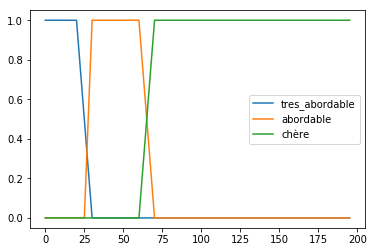

In [126]:
cout_faible = fuzz.trapmf(offre.universe, [0, 0, 20,30])
cout_moyen = fuzz.trapmf(offre.universe, [25, 30, 60,70])
cout_eleve = fuzz.trapmf(offre.universe, [60, 70, 200, 200])
offre['tres_abordable'] = cout_faible
offre['abordable'] = cout_moyen
offre['chere'] = cout_eleve
#juste pour voir les courbes
plt.plot(offre.universe, cout_faible, label='tres_abordable')
plt.plot(offre.universe, cout_moyen,  label='abordable')
plt.plot(offre.universe, cout_eleve,  label='chère')
plt.legend()
plt.show()

- une durée de séjour est considérée longue à partir de 3j
- une durée est moyenne entre 2j et 3j
- une courte durée tient de 1j à 2j
- ne pas partir reviens à une durée de 0j à 1j



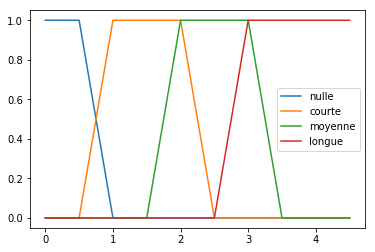

In [127]:
duree_nulle = fuzz.trapmf(duree.universe, [0, 0, 0.5,1])
duree_courte = fuzz.trapmf(duree.universe, [0.75, 1, 2,2.5])
duree_moyenne = fuzz.trapmf(duree.universe, [1.5, 2, 3, 3.5])
duree_longue = fuzz.trapmf(duree.universe, [2.5, 3, 5, 5])
duree['nulle'] = duree_nulle
duree['courte'] = duree_courte
duree['moyenne'] = duree_moyenne
duree['longue'] = duree_longue
#juste pour voir les courbes
plt.plot(duree.universe, duree_nulle,  label='nulle')
plt.plot(duree.universe, duree_courte, label='courte')
plt.plot(duree.universe, duree_moyenne,label='moyenne')
plt.plot(duree.universe, duree_longue, label='longue')
plt.legend()
plt.show()

##Définition des règles floues
Rappel, on souhaite définir : 
- si le beau temps est prévu alors j’achète l’offre de location pour une longue durée
- si le temps est de moyen, et que la location reste abordable, alors j’achète l’offre pour une moyenne durée
- si le temps prévu est mauvais, mais que la location est très abordable, alors j’achète l’offre pour une courte durée
- le reste du temps, si la location est chère et qu’il ne fait pas beau, je n’y vais pas ; de même si la location est dans des prix abordable mais qu’il fait mauvais



In [0]:
#on écrit
rule1 =  ctrl.Rule( meteo['belle'],                            duree['longue'])
rule2 =  ctrl.Rule( meteo['moyenne'] & offre['abordable'],     duree['moyenne'])
rule3 =  ctrl.Rule( meteo['moche']   & offre['tres_abordable'],duree['courte'])
rule4a = ctrl.Rule( meteo['moche']   & offre['chere'],         duree['nulle'])
rule4b = ctrl.Rule( meteo['moche']   & offre['abordable'],     duree['nulle'])
rule4c = ctrl.Rule( meteo['moyenne'] & offre['chere'],         duree['nulle'])



#on compile les règles
sejour_regles = ctrl.ControlSystem([rule1, rule2, rule3, rule4a, rule4b, rule4c])
sejour_decision = ctrl.ControlSystemSimulation(sejour_regles)

##Observations
Testons le système : 
- une offre à 70€ est repérée et la météo annonce 17°, quelle est la décision à prendre ?

In [129]:
sejour_decision.input['meteo'] = 17
sejour_decision.input['offre'] = 70

sejour_decision.compute()

print(sejour_decision.output['duree'])

0.38888888888888884


la durée est <0.5, ce qui correspond à une durée nulle.

Vérifions en image :

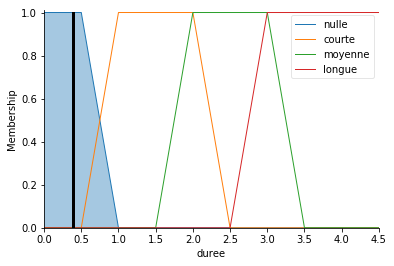

In [130]:
duree.view(sim=sejour_decision)

Que se passe-t-il lorsqu'une offre est trouvée à 80€ mais que la météo annonce 30° ?


In [133]:
sejour_decision.input['meteo'] = 30
sejour_decision.input['offre'] = 80

sejour_decision.compute()

print(sejour_decision.output['duree'])

3.6190476190476195


une durée de séjour longue est recomandée. vérification en image :

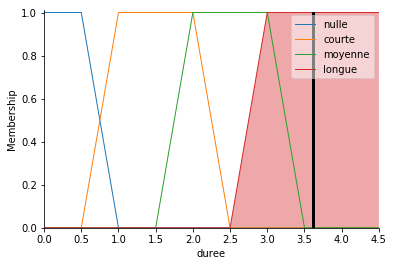

In [134]:
duree.view(sim=sejour_decision)